In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- 1. For data loading ---
def load_data(file_path):
    df = pd.read_excel(file_path, parse_dates=['timestamp'], index_col='timestamp')
    df = df.asfreq('B').sort_index() 
    df = df[['open', 'high', 'low', 'close', 'volume']].ffill()
    return df

In [3]:
# --- 2. ENHANCED TREND DETECTION FUNCTIONS ---
def create_trend_features(df):
    """Create robust trend detection features with emphasis on recent data."""
    features = pd.DataFrame(index=df.index)
    
    # 1. Multiple timeframe Moving Averages with exponential weighting
    for span in [10, 20, 50, 100, 200]:
        features[f'ema_{span}'] = df['close'].ewm(span=span, adjust=False).mean()
    
    # 2. Price relative to EMAs (more sensitive to recent price action)
    for span in [20, 50, 100]:
        features[f'price_to_ema{span}'] = df['close'] / features[f'ema_{span}'] - 1
    
    # 3. Moving average slopes with higher weight to recent changes
    features['ema20_slope'] = features['ema_20'].diff(5) / features['ema_20'].shift(5)
    features['ema50_slope'] = features['ema_50'].diff(10) / features['ema_50'].shift(10)
    features['ema100_slope'] = features['ema_100'].diff(20) / features['ema_100'].shift(20)
    
    # 4. EMA crossovers (powerful trend signals)
    features['ema_cross_20_50'] = features['ema_20'] - features['ema_50']
    features['ema_cross_50_100'] = features['ema_50'] - features['ema_100']
    
    # 5. Momentum indicators with exponential weighting
    features['rsi'] = calculate_weighted_rsi(df['close'], 14)
    features['adx'] = calculate_adx(df, 14)
    
    # 6. Volatility indicators
    features['atr'] = calculate_atr(df, 14)
    features['atr_percent'] = features['atr'] / df['close'] * 100
    
    # 7. Volume trend confirmation
    features['volume_ema'] = df['volume'].ewm(span=20, adjust=False).mean()
    features['volume_ratio'] = df['volume'] / features['volume_ema']
    
    # 8. Enhanced trend classification with distinct thresholds
    # Short-term trend (20-day)
    features['trend_20d'] = 0 # Initialize as neutral
    features.loc[features['price_to_ema20'] > 0.01, 'trend_20d'] = 1 # Bullish
    features.loc[features['price_to_ema20'] > 0.03, 'trend_20d'] = 2 # Very bullish
    features.loc[features['price_to_ema20'] < -0.01, 'trend_20d'] = -1 # Bearish
    features.loc[features['price_to_ema20'] < -0.03, 'trend_20d'] = -2 # Very bearish
    
    # Medium-term trend (50-day)
    features['trend_50d'] = 0 # Initialize as neutral
    features.loc[features['price_to_ema50'] > 0.02, 'trend_50d'] = 1 # Bullish
    features.loc[features['price_to_ema50'] > 0.05, 'trend_50d'] = 2 # Very bullish
    features.loc[features['price_to_ema50'] < -0.02, 'trend_50d'] = -1 # Bearish
    features.loc[features['price_to_ema50'] < -0.05, 'trend_50d'] = -2 # Very bearish
    
    # Long-term trend (100-day)
    features['trend_100d'] = 0 # Initialize as neutral
    features.loc[features['price_to_ema100'] > 0.03, 'trend_100d'] = 1 # Bullish
    features.loc[features['price_to_ema100'] > 0.07, 'trend_100d'] = 2 # Very bullish
    features.loc[features['price_to_ema100'] < -0.03, 'trend_100d'] = -1 # Bearish
    features.loc[features['price_to_ema100'] < -0.07, 'trend_100d'] = -2 # Very bearish
    
    # 9. Enhanced trend score with multiple timeframes
    features['trend_score'] = (0.5 * features['trend_20d'] + 
                              0.3 * features['trend_50d'] + 
                              0.2 * features['trend_100d'])
    
    # Add RSI and ADX confirmation
    # RSI above 60 confirms bullish, below 40 confirms bearish
    rsi_factor = pd.Series(0, index=features.index)
    rsi_factor.loc[features['rsi'] > 60] = 0.2
    rsi_factor.loc[features['rsi'] < 40] = -0.2
    
    # ADX above 25 confirms trend strength
    adx_factor = pd.Series(0, index=features.index)
    adx_factor.loc[features['adx'] > 25] = 0.1
    adx_factor.loc[features['adx'] > 35] = 0.2
    
    # Apply confirmation factors
    features['trend_score'] = features['trend_score'] + (np.sign(features['trend_score']) * adx_factor)
    features['trend_score'] = features['trend_score'] + rsi_factor
    
    # 10. Final trend classification with clear boundaries
    features['trend_class'] = 2 # Default: Neutral
    features.loc[features['trend_score'] > 0.5, 'trend_class'] = 3 # Bullish
    features.loc[features['trend_score'] > 1.2, 'trend_class'] = 4 # Very Bullish
    features.loc[features['trend_score'] < -0.5, 'trend_class'] = 1 # Bearish
    features.loc[features['trend_score'] < -1.2, 'trend_class'] = 0 # Very Bearish
    
    return features


def calculate_weighted_rsi(prices, window=14):
    """Calculate RSI with exponential weighting for recent data."""
    prices = prices.fillna(method='ffill')
    delta = prices.diff()
    
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Use exponential weighting to emphasize recent data
    avg_gain = gain.ewm(com=window-1, adjust=False).mean()
    avg_loss = loss.ewm(com=window-1, adjust=False).mean()
    
    # Avoid division by zero
    avg_loss = avg_loss.replace(0, 0.0001)
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_adx(df, window=14):
    """Calculate ADX with error handling."""
    high, low, close = df['high'], df['low'], df['close']
    
    # Handle potential NaN values
    high = high.fillna(method='ffill')
    low = low.fillna(method='ffill')
    close = close.fillna(method='ffill')
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    minus_dm = abs(minus_dm)
    
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    # Avoid division by zero
    atr = tr.rolling(window).mean()
    atr = atr.replace(0, 0.0001)
    
    plus_di = 100 * (plus_dm.rolling(window).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window).mean() / atr)
    
    # Avoid division by zero
    denominator = plus_di + minus_di
    denominator = denominator.replace(0, 0.0001)
    
    dx = 100 * abs(plus_di - minus_di) / denominator
    adx = dx.rolling(window).mean()
    return adx

def calculate_atr(df, window=14):
    """Calculate Average True Range."""
    high, low, close = df['high'], df['low'], df['close']
    
    # Handle potential NaN values
    high = high.fillna(method='ffill')
    low = low.fillna(method='ffill')
    close = close.fillna(method='ffill')
    
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    
    atr = tr.rolling(window).mean()
    return atr

In [4]:
# --- 3. ENHANCED TREND DETECTOR CLASS ---
class EnhancedTrendDetector:
    def __init__(self, smoothing_factor=5, change_threshold=0.3):
        self.smoothing_factor = smoothing_factor
        self.change_threshold = change_threshold
    
    def detect_trends(self, df):
        """Detect market trends with emphasis on recent data."""
        features = create_trend_features(df)
        
        # Apply persistence filter to prevent rapid switching
        trend_class = features['trend_class'].copy()
        smoothed_trend = self._apply_persistence_filter(trend_class, features['trend_score'])
        
        # Add smoothed trend back to features
        features['smoothed_trend'] = smoothed_trend
        
        return features
    
    def _apply_persistence_filter(self, trend_series, score_series):
        """Apply enhanced persistence filter to prevent rapid switching between regimes."""
        smoothed = trend_series.copy()
        current_trend = None
        trend_start_idx = 0
        
        for i, (idx, trend) in enumerate(trend_series.items()):
            if pd.isna(trend):
                continue
            
            if current_trend is None:
                current_trend = trend
                trend_start_idx = i
                continue
            
            if trend != current_trend:
                # Check if the previous trend lasted long enough
                if i - trend_start_idx < self.smoothing_factor:
                    # If not, keep the previous trend
                    indices = trend_series.index[trend_start_idx:i]
                    smoothed.loc[indices] = current_trend
                else:
                    # Check if the trend score change is significant enough
                    current_score = score_series.iloc[i]
                    prev_score = score_series.iloc[trend_start_idx]
                    
                    if abs(current_score - prev_score) < self.change_threshold:
                        # If change is not significant, maintain previous trend
                        smoothed.loc[idx] = current_trend
                    else:
                        # Otherwise, update the current trend
                        current_trend = trend
                        trend_start_idx = i
        
        return smoothed

In [5]:
# --- 4. ADVANCED MACHINE LEARNING INTEGRATION ---
class MLTrendPredictor:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        
    def prepare_features(self, features):
        """Prepare features for ML models."""
        ml_features = features.copy()
        
        # Add additional features for ML models
        ml_features['rsi_slope'] = ml_features['rsi'].diff(5) / 5
        ml_features['adx_slope'] = ml_features['adx'].diff(5) / 5
        
        # Add cyclical features
        ml_features['day_of_week'] = ml_features.index.dayofweek
        ml_features['month'] = ml_features.index.month
        
        # Create target variables
        ml_features['future_return_5d'] = ml_features['close'].pct_change(5).shift(-5)
        ml_features['future_return_10d'] = ml_features['close'].pct_change(10).shift(-10)
        
        # Create binary target for direction prediction - ensure it's integer type
        ml_features['future_direction_5d'] = (ml_features['future_return_5d'] > 0).astype(int)
        
        # Drop NaN values
        ml_features = ml_features.dropna()
        
        return ml_features
    
    def train_models(self, ml_features):
        """Train ML models for trend prediction."""
        from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score
        
        # Feature columns for training
        feature_cols = ['rsi', 'adx', 'atr_percent', 'volume_ratio', 
                        'price_to_ema20', 'price_to_ema50', 'price_to_ema100',
                        'ema20_slope', 'ema50_slope', 'rsi_slope', 'adx_slope',
                        'day_of_week', 'month']
        
        # Scale features
        X = self.scaler.fit_transform(ml_features[feature_cols])
        
        # Direction prediction model
        y_dir = ml_features['future_direction_5d'].astype(int)  # Ensure integer type
        X_train, X_test, y_train, y_test = train_test_split(X, y_dir, test_size=0.3, shuffle=False)
        
        dir_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        dir_model.fit(X_train, y_train)
        self.models['direction'] = dir_model
        
        # Calculate accuracy manually to avoid the error
        y_pred = dir_model.predict(X_test)
        direction_accuracy = accuracy_score(y_test, y_pred)
        
        # Return magnitude prediction model
        y_ret = ml_features['future_return_5d']
        X_train, X_test, y_train, y_test = train_test_split(X, y_ret, test_size=0.3, shuffle=False)
        
        ret_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
        ret_model.fit(X_train, y_train)
        self.models['magnitude'] = ret_model
        
        # Store feature columns for prediction
        self.feature_cols = feature_cols
        
        return {'direction_accuracy': direction_accuracy}
    
    def predict(self, features):
        """Make predictions using trained models."""
        if not self.models:
            return None
        
        # Prepare features for prediction
        pred_features = features[self.feature_cols].copy()
        X = self.scaler.transform(pred_features)
        
        # Make predictions
        direction_prob = self.models['direction'].predict_proba(X)[:, 1]
        magnitude = self.models['magnitude'].predict(X)
        
        # Convert probabilities to binary predictions (0 or 1)
        direction_pred = (direction_prob > 0.5).astype(int)
        
        return pd.DataFrame({
            'direction_prob': direction_prob,
            'direction_pred': direction_pred,  # Add binary predictions
            'magnitude': magnitude,
            'ml_signal': direction_prob * magnitude * 100  # Combined signal
        }, index=features.index)

In [6]:
# --- 5. ADAPTIVE TRADING STRATEGY ---
class AdaptiveMultiStrategyTrader:
    def __init__(self, df, features, ml_predictions=None):
        self.df = df.copy()
        self.features = features.copy()
        self.ml_predictions = ml_predictions
        
        self.initial_capital = 100000
        self.capital = self.initial_capital
        self.equity_curve = [self.capital]
        self.positions = []
        self.trades = []
        self.max_equity = self.capital
        self.drawdown = 0
        
        # Strategy parameters
        self.base_risk = 0.01  # 1% of capital per trade
        self.max_risk = 0.03   # Maximum risk per trade
        self.max_drawdown_allowed = 0.15  # 15% max drawdown
        self.max_positions = 5  # Maximum open positions
        self.profit_target_ratio = {
            'trend_following': 2.0,  # Risk-reward ratio for trend following
            'mean_reversion': 1.5,   # Risk-reward ratio for mean reversion
            'ml_based': 2.5          # Risk-reward ratio for ML-based trades
        }
        
        # Strategy weights based on market regime
        self.strategy_weights = {
            0: {'trend_following': 0.2, 'mean_reversion': 0.6, 'ml_based': 0.2},  # Very Bearish
            1: {'trend_following': 0.3, 'mean_reversion': 0.5, 'ml_based': 0.2},  # Bearish
            2: {'trend_following': 0.3, 'mean_reversion': 0.4, 'ml_based': 0.3},  # Neutral
            3: {'trend_following': 0.5, 'mean_reversion': 0.3, 'ml_based': 0.2},  # Bullish
            4: {'trend_following': 0.6, 'mean_reversion': 0.2, 'ml_based': 0.2}   # Very Bullish
        }
    
    def run(self):
        """Execute the strategy on historical data."""
        # Combine price data with features and ML predictions
        data = pd.concat([self.df, self.features], axis=1)
        if self.ml_predictions is not None:
            data = pd.concat([data, self.ml_predictions], axis=1)
        data = data.dropna()
        
        # Loop through each day
        for i in range(20, len(data)):  # Start after enough data for indicators
            current_date = data.index[i]
            row = data.iloc[i]
            
            # Update existing positions first
            self.update_positions(current_date, row, data)
            
            # Skip new entries if we've hit max drawdown
            current_drawdown = (self.max_equity - self.capital) / self.max_equity if self.max_equity > 0 else 0
            if current_drawdown > self.max_drawdown_allowed:
                continue
            
            # Check if we can open new positions
            if len([p for p in self.positions if p['open']]) >= self.max_positions:
                continue
            
            # Determine current market regime
            market_regime = int(row['trend_class'])
            
            # Get strategy weights for current regime
            weights = self.strategy_weights[market_regime]
            
            # Check for trend following signals
            if self.check_trend_following_entry(row, data, i) and np.random.random() < weights['trend_following']:
                self.open_position('trend_following', current_date, row, data, i)
            
            # Check for mean reversion signals
            if self.check_mean_reversion_entry(row, data, i) and np.random.random() < weights['mean_reversion']:
                self.open_position('mean_reversion', current_date, row, data, i)
            
            # Check for ML-based signals
            if self.ml_predictions is not None and self.check_ml_entry(row, data, i) and np.random.random() < weights['ml_based']:
                self.open_position('ml_based', current_date, row, data, i)
            
            # Track equity
            current_equity = self.capital + self.unrealized_pnl(current_date, data)
            self.equity_curve.append(current_equity)
            self.max_equity = max(self.max_equity, current_equity)
            current_drawdown = (self.max_equity - current_equity) / self.max_equity if self.max_equity > 0 else 0
            self.drawdown = max(self.drawdown, current_drawdown)
        
        # Close all positions at the end
        for pos in self.positions:
            if pos['open']:
                self.close_position(pos, data.index[-1], data.iloc[-1]['close'], "End of Backtest")
        
        return self.calculate_performance_metrics()
    
    def check_trend_following_entry(self, row, data, i):
        """Check for trend following entry signals."""
        # For bullish trend following entries
        if row['trend_class'] in [3, 4]:  # Bullish or Very Bullish
            # Confirm with additional indicators
            if (row['adx'] > 25 and  # Strong trend
                row['rsi'] > 50 and  # RSI confirms uptrend
                row['ema_cross_20_50'] > 0):  # 20 EMA above 50 EMA
                return {'direction': 'long', 'strategy': 'trend_following'}
        
        # For bearish trend following entries
        if row['trend_class'] in [0, 1]:  # Bearish or Very Bearish
            # Confirm with additional indicators
            if (row['adx'] > 25 and  # Strong trend
                row['rsi'] < 50 and  # RSI confirms downtrend
                row['ema_cross_20_50'] < 0):  # 20 EMA below 50 EMA
                return {'direction': 'short', 'strategy': 'trend_following'}
        
        return None
    
    def check_mean_reversion_entry(self, row, data, i):
        """Check for mean reversion entry signals."""
        # For bullish mean reversion entries (oversold conditions)
        if row['trend_class'] in [1, 2]:  # Bearish or Neutral
            # Look for oversold conditions
            if (row['rsi'] < 30 and  # Oversold RSI
                row['price_to_ema20'] < -0.02 and  # Price well below 20 EMA
                row['adx'] < 25):  # Weak trend (mean reversion works better in ranging markets)
                return {'direction': 'long', 'strategy': 'mean_reversion'}
        
        # For bearish mean reversion entries (overbought conditions)
        if row['trend_class'] in [2, 3]:  # Neutral or Bullish
            # Look for overbought conditions
            if (row['rsi'] > 70 and  # Overbought RSI
                row['price_to_ema20'] > 0.02 and  # Price well above 20 EMA
                row['adx'] < 25):  # Weak trend
                return {'direction': 'short', 'strategy': 'mean_reversion'}
        
        return None
    
    def check_ml_entry(self, row, data, i):
        """Check for ML-based entry signals."""
        if 'ml_signal' not in row:
            return None
        
        # Use binary direction prediction instead of continuous signal
        if 'direction_pred' in row:
            # For bullish ML entries
            if row['direction_pred'] == 1:  # Binary prediction for up
                return {'direction': 'long', 'strategy': 'ml_based'}
            
            # For bearish ML entries
            if row['direction_pred'] == 0:  # Binary prediction for down
                return {'direction': 'short', 'strategy': 'ml_based'}
        else:
            # Fallback to threshold on ml_signal if direction_pred not available
            if row['ml_signal'] > 0.5:  # Strong positive signal
                return {'direction': 'long', 'strategy': 'ml_based'}
            
            if row['ml_signal'] < -0.5:  # Strong negative signal
                return {'direction': 'short', 'strategy': 'ml_based'}
        
        return None
    
    def open_position(self, strategy_type, date, row, data, index):
        """Open a new position based on strategy type."""
        # Get entry signal
        if strategy_type == 'trend_following':
            signal = self.check_trend_following_entry(row, data, index)
        elif strategy_type == 'mean_reversion':
            signal = self.check_mean_reversion_entry(row, data, index)
        elif strategy_type == 'ml_based':
            signal = self.check_ml_entry(row, data, index)
        else:
            return
        
        if not signal:
            return
        
        direction = signal['direction']
        strategy = signal['strategy']
        
        # Calculate position size based on risk and strategy
        risk_multiplier = {
            'trend_following': 1.0,
            'mean_reversion': 0.8,  # Lower risk for mean reversion
            'ml_based': 1.2  # Higher risk for ML-based trades if confident
        }
        
        # Adjust risk based on market conditions
        if row['atr_percent'] > 1.0:  # High volatility
            risk_multiplier[strategy] *= 0.7
        
        # Adjust risk based on drawdown
        current_drawdown = (self.max_equity - self.capital) / self.max_equity if self.max_equity > 0 else 0
        if current_drawdown > 0.1:
            risk_multiplier[strategy] *= 0.5
        
        # Calculate risk amount
        risk_amount = self.capital * self.base_risk * risk_multiplier[strategy]
        risk_amount = min(risk_amount, self.capital * self.max_risk)
        
        # Set stop loss and take profit levels based on ATR
        atr = row['atr']
        
        if strategy == 'trend_following':
            sl_multiplier = 1.5
            tp_multiplier = max(self.profit_target_ratio[strategy] * sl_multiplier, 3)
        elif strategy == 'mean_reversion':
            sl_multiplier = 1.5
            tp_multiplier = max(self.profit_target_ratio[strategy] * sl_multiplier, 2.5)
        else:  # ml_based
            sl_multiplier = 1.5
            tp_multiplier = max(self.profit_target_ratio[strategy] * sl_multiplier, 3)
        
        if direction == 'long':
            entry_price = row['close']
            stop_loss = entry_price - (sl_multiplier * atr)
            take_profit = entry_price + (tp_multiplier * atr)
        else:  # short
            entry_price = row['close']
            stop_loss = entry_price + (sl_multiplier * atr)
            take_profit = entry_price - (tp_multiplier * atr)
        
        # Calculate position size based on risk
        risk_per_unit = abs(entry_price - stop_loss)
        position_size = risk_amount / risk_per_unit
        
        # Create position record
        position = {
            'strategy': strategy,
            'direction': direction,
            'open': True,
            'entry_date': date,
            'entry_price': entry_price,
            'size': position_size,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'initial_stop': stop_loss,  # Keep track of initial stop
            'trailing_stop': stop_loss,  # Trailing stop starts at initial stop
            'atr_at_entry': atr,
            'trend_class': row['trend_class'],
            'days_held': 0,
            'entry_equity': self.capital
        }
        
        self.positions.append(position)
    
    def update_positions(self, date, row, data):
        """Update all open positions."""
        for pos in self.positions:
            if not pos['open']:
                continue
            
            # Increment days held
            pos['days_held'] += 1
            
            # Check exit conditions
            exit_signal = False
            exit_reason = ""
            
            # 1. Stop loss hit
            if pos['direction'] == 'long' and row['low'] <= pos['trailing_stop']:
                exit_signal = True
                exit_reason = "Stop Loss"
                exit_price = pos['trailing_stop']  # Assume we exit at stop price
            elif pos['direction'] == 'short' and row['high'] >= pos['trailing_stop']:
                exit_signal = True
                exit_reason = "Stop Loss"
                exit_price = pos['trailing_stop']  # Assume we exit at stop price
            
            # 2. Take profit hit
            elif pos['direction'] == 'long' and row['high'] >= pos['take_profit']:
                exit_signal = True
                exit_reason = "Take Profit"
                exit_price = pos['take_profit']  # Assume we exit at target price
            elif pos['direction'] == 'short' and row['low'] <= pos['take_profit']:
                exit_signal = True
                exit_reason = "Take Profit"
                exit_price = pos['take_profit']  # Assume we exit at target price
            
            # 3. Strategy-specific exit conditions
            elif self.check_strategy_exit(pos, row):
                exit_signal = True
                exit_reason = "Strategy Exit"
                exit_price = row['close']
            
            # 4. Time-based exit (max holding period based on strategy)
            elif (pos['strategy'] == 'trend_following' and pos['days_held'] > 20) or \
                 (pos['strategy'] == 'mean_reversion' and pos['days_held'] > 10) or \
                 (pos['strategy'] == 'ml_based' and pos['days_held'] > 15):
                exit_signal = True
                exit_reason = "Time Exit"
                exit_price = row['close']
            
            # Update trailing stop for winning positions
            if not exit_signal:
                self.update_trailing_stop(pos, row)
            
            # Close position if exit signal triggered
            if exit_signal:
                self.close_position(pos, date, exit_price, exit_reason)
    
    def check_strategy_exit(self, position, row):
        """Check for strategy-specific exit signals."""
        strategy = position['strategy']
        direction = position['direction']
        
        if strategy == 'trend_following':
            # Exit trend following positions on trend reversal
            if direction == 'long' and row['trend_class'] <= 1:  # Trend turned bearish
                return True
            if direction == 'short' and row['trend_class'] >= 3:  # Trend turned bullish
                return True
        
        elif strategy == 'mean_reversion':
            # Exit mean reversion positions when price returns to mean
            if direction == 'long' and row['price_to_ema20'] > 0:  # Price above 20 EMA
                return True
            if direction == 'short' and row['price_to_ema20'] < 0:  # Price below 20 EMA
                return True
        
        elif strategy == 'ml_based':
            # Exit ML-based positions when ML signal reverses
            if 'direction_pred' in row:
                if direction == 'long' and row['direction_pred'] == 0:  # Binary prediction changed to down
                    return True
                if direction == 'short' and row['direction_pred'] == 1:  # Binary prediction changed to up
                    return True
            elif 'ml_signal' in row:
                if direction == 'long' and row['ml_signal'] < 0:
                    return True
                if direction == 'short' and row['ml_signal'] > 0:
                    return True
        
        return False
    
    def update_trailing_stop(self, position, row):
        """Update trailing stop for winning positions."""
        strategy = position['strategy']
        direction = position['direction']
        
        # Calculate current profit
        if direction == 'long':
            profit_pct = (row['close'] - position['entry_price']) / position['entry_price']
        else:  # short
            profit_pct = (position['entry_price'] - row['close']) / position['entry_price']
        
        # Only trail once in profit
        if profit_pct <= 0:
            return
        
        # Different trailing logic based on strategy
        if strategy == 'trend_following':
            # More aggressive trailing for trend following
            if profit_pct > 0.01:  # 1% profit
                atr_multiplier = max(0.8, 2.0 - profit_pct * 10)  # Tighten as profit grows
                if direction == 'long':
                    new_stop = row['close'] - (atr_multiplier * row['atr'])
                    position['trailing_stop'] = max(position['trailing_stop'], new_stop)
                else:  # short
                    new_stop = row['close'] + (atr_multiplier * row['atr'])
                    position['trailing_stop'] = min(position['trailing_stop'], new_stop)
        
        elif strategy == 'mean_reversion':
            # Tighter trailing for mean reversion
            if profit_pct > 0.005:  # 0.5% profit
                atr_multiplier = max(0.5, 1.0 - profit_pct * 10)  # Tighter stops
                if direction == 'long':
                    new_stop = row['close'] - (atr_multiplier * row['atr'])
                    position['trailing_stop'] = max(position['trailing_stop'], new_stop)
                else:  # short
                    new_stop = row['close'] + (atr_multiplier * row['atr'])
                    position['trailing_stop'] = min(position['trailing_stop'], new_stop)
        
        elif strategy == 'ml_based':
            # Dynamic trailing based on ML confidence
            ml_confidence = abs(row.get('ml_signal', 0))
            if profit_pct > 0.01:  # 1% profit
                atr_multiplier = max(0.7, 1.5 - profit_pct * 10 - ml_confidence * 0.5)
                if direction == 'long':
                    new_stop = row['close'] - (atr_multiplier * row['atr'])
                    position['trailing_stop'] = max(position['trailing_stop'], new_stop)
                else:  # short
                    new_stop = row['close'] + (atr_multiplier * row['atr'])
                    position['trailing_stop'] = min(position['trailing_stop'], new_stop)
    
    def close_position(self, position, date, exit_price, exit_reason):
        """Close a position and record the trade."""
        if not position['open']:
            return
        
        # Calculate P&L
        if position['direction'] == 'long':
            pnl = (exit_price - position['entry_price']) * position['size']
        else:  # short
            pnl = (position['entry_price'] - exit_price) * position['size']
        
        # Update capital
        self.capital += pnl
        
        # Update position record
        position['open'] = False
        position['exit_date'] = date
        position['exit_price'] = exit_price
        position['pnl'] = pnl
        position['pnl_percent'] = pnl / position['entry_equity'] * 100
        position['exit_reason'] = exit_reason
        
        # Add to closed trades list
        self.trades.append(position)
    
    def unrealized_pnl(self, date, data):
        """Calculate unrealized P&L for all open positions."""
        current_price = data.loc[date, 'close']
        pnl = 0
        
        for pos in self.positions:
            if pos['open']:
                if pos['direction'] == 'long':
                    pnl += (current_price - pos['entry_price']) * pos['size']
                else:  # short
                    pnl += (pos['entry_price'] - current_price) * pos['size']
        
        return pnl
    
    def calculate_performance_metrics(self):
        """Calculate performance metrics."""
        if not self.trades:
            print("No trades executed.")
            return {}
        
        # Create trade summary DataFrame
        trades_df = pd.DataFrame(self.trades)
        
        # Convert equity curve to DataFrame for easier analysis
        equity_curve_df = pd.DataFrame({
            'equity': self.equity_curve
        })
        
        # Calculate daily returns
        equity_curve_df['return'] = equity_curve_df['equity'].pct_change()
        
        # Calculate performance metrics
        total_return = (self.capital - self.initial_capital) / self.initial_capital
        win_trades = trades_df[trades_df['pnl'] > 0]
        loss_trades = trades_df[trades_df['pnl'] <= 0]
        
        win_rate = len(win_trades) / len(trades_df) if len(trades_df) > 0 else 0
        avg_win = win_trades['pnl'].mean() if not win_trades.empty else 0
        avg_loss = loss_trades['pnl'].mean() if not loss_trades.empty else 0
        
        # Calculate profit factor
        gross_profit = win_trades['pnl'].sum() if not win_trades.empty else 0
        gross_loss = abs(loss_trades['pnl'].sum()) if not loss_trades.empty else 1  # Avoid division by zero
        profit_factor = gross_profit / gross_loss
        
        # Calculate Sharpe ratio (assuming 252 trading days per year)
        daily_returns = equity_curve_df['return'].dropna()
        sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0
        
        # Calculate Sortino ratio (using only negative returns)
        negative_returns = daily_returns[daily_returns < 0]
        sortino_ratio = (daily_returns.mean() / negative_returns.std()) * np.sqrt(252) if negative_returns.std() > 0 else 0
        
        # Calculate maximum drawdown
        max_drawdown = self.drawdown * 100  # Convert to percentage
        
        # Calculate annualized return
        num_years = len(daily_returns) / 252
        annualized_return = (1 + total_return) ** (1 / num_years) - 1 if num_years > 0 else 0
        
        # Calculate strategy-specific metrics
        strategy_metrics = trades_df.groupby('strategy').agg(
            count=('pnl', 'count'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100),
            avg_profit=('pnl', 'mean'),
            total_profit=('pnl', 'sum'),
            avg_hold=('days_held', 'mean')
        )
        
        # Print summary statistics
        print(f"\n{'='*50}")
        print(f"STRATEGY PERFORMANCE SUMMARY")
        print(f"{'='*50}")
        print(f"Total Return: {total_return * 100:.2f}%")
        print(f"Annualized Return: {annualized_return * 100:.2f}%")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Sortino Ratio: {sortino_ratio:.2f}")
        print(f"Win Rate: {win_rate * 100:.2f}%")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Average Win: ${avg_win:.2f}")
        print(f"Average Loss: ${avg_loss:.2f}")
        print(f"Maximum Drawdown: {max_drawdown:.2f}%")
        print(f"Total Trades: {len(trades_df)}")
        print(f"{'='*50}")
        print("\nStrategy Breakdown:")
        print(strategy_metrics)
        print(f"{'='*50}")
        
        # Plot equity curve
        self.plot_equity_curve(equity_curve_df)
        
        # Plot trade distribution by strategy
        self.plot_trade_distribution(trades_df)
        
        # Return results as dictionary
        return {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'max_drawdown': max_drawdown,
            'total_trades': len(trades_df),
            'trades': trades_df,
            'equity_curve': equity_curve_df,
            'strategy_metrics': strategy_metrics
        }
    
    def plot_equity_curve(self, equity_df):
        """Plot equity curve with drawdowns."""
        plt.figure(figsize=(14, 8))
        
        # Create equity curve plot
        ax1 = plt.subplot(2, 1, 1)
        equity_df['equity'].plot(ax=ax1, color='blue', linewidth=2)
        ax1.set_title('Equity Curve and Drawdown', fontsize=14)
        ax1.set_ylabel('Equity ($)', fontsize=12)
        ax1.grid(True)
        
        # Calculate drawdown series
        equity_df['peak'] = equity_df['equity'].cummax()
        equity_df['drawdown'] = (equity_df['equity'] - equity_df['peak']) / equity_df['peak'] * 100
        
        # Create drawdown plot
        ax2 = plt.subplot(2, 1, 2, sharex=ax1)
        equity_df['drawdown'].plot(ax=ax2, color='red', linewidth=1.5)
        ax2.fill_between(equity_df.index, equity_df['drawdown'], 0, color='red', alpha=0.3)
        ax2.set_ylabel('Drawdown (%)', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.grid(True)
        
        # Set y-limit for drawdown plot to make it more readable
        ax2.set_ylim(min(equity_df['drawdown']) * 1.1, 1)
        
        plt.tight_layout()
        plt.show()
    
    def plot_trade_distribution(self, trades_df):
        """Plot trade distribution by strategy and trend class."""
        if trades_df.empty:
            return
        
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Trade count by strategy
        ax1 = plt.subplot(2, 2, 1)
        strategy_counts = trades_df['strategy'].value_counts()
        strategy_counts.plot(kind='bar', ax=ax1, color='skyblue')
        ax1.set_title('Trade Count by Strategy', fontsize=12)
        ax1.set_ylabel('Number of Trades', fontsize=10)
        
        # Plot 2: Win rate by strategy
        ax2 = plt.subplot(2, 2, 2)
        strategy_win_rates = trades_df.groupby('strategy')['pnl'].apply(lambda x: (x > 0).mean() * 100)
        strategy_win_rates.plot(kind='bar', ax=ax2, color='green')
        ax2.set_title('Win Rate by Strategy (%)', fontsize=12)
        ax2.set_ylabel('Win Rate (%)', fontsize=10)
        ax2.axhline(y=50, color='r', linestyle='-', alpha=0.3)
        
        # Plot 3: Trade count by trend class
        ax3 = plt.subplot(2, 2, 3)
        trend_labels = ['Very Bearish', 'Bearish', 'Neutral', 'Bullish', 'Very Bullish']
        trend_counts = trades_df['trend_class'].value_counts().sort_index()
        trend_counts.index = [trend_labels[int(i)] for i in trend_counts.index]
        trend_counts.plot(kind='bar', ax=ax3, color='purple')
        ax3.set_title('Trade Count by Market Regime', fontsize=12)
        ax3.set_ylabel('Number of Trades', fontsize=10)
        
        # Plot 4: Average profit by strategy
        ax4 = plt.subplot(2, 2, 4)
        avg_profit = trades_df.groupby('strategy')['pnl'].mean()
        avg_profit.plot(kind='bar', ax=ax4, color='orange')
        ax4.set_title('Average Profit by Strategy ($)', fontsize=12)
        ax4.set_ylabel('Average Profit ($)', fontsize=10)
        
        plt.tight_layout()
        plt.show()


Trend Distribution:
Very Bearish: 834 days (16.4%)
Bearish: 468 days (9.2%)
Neutral: 822 days (16.2%)
Bullish: 703 days (13.9%)
Very Bullish: 2246 days (44.3%)


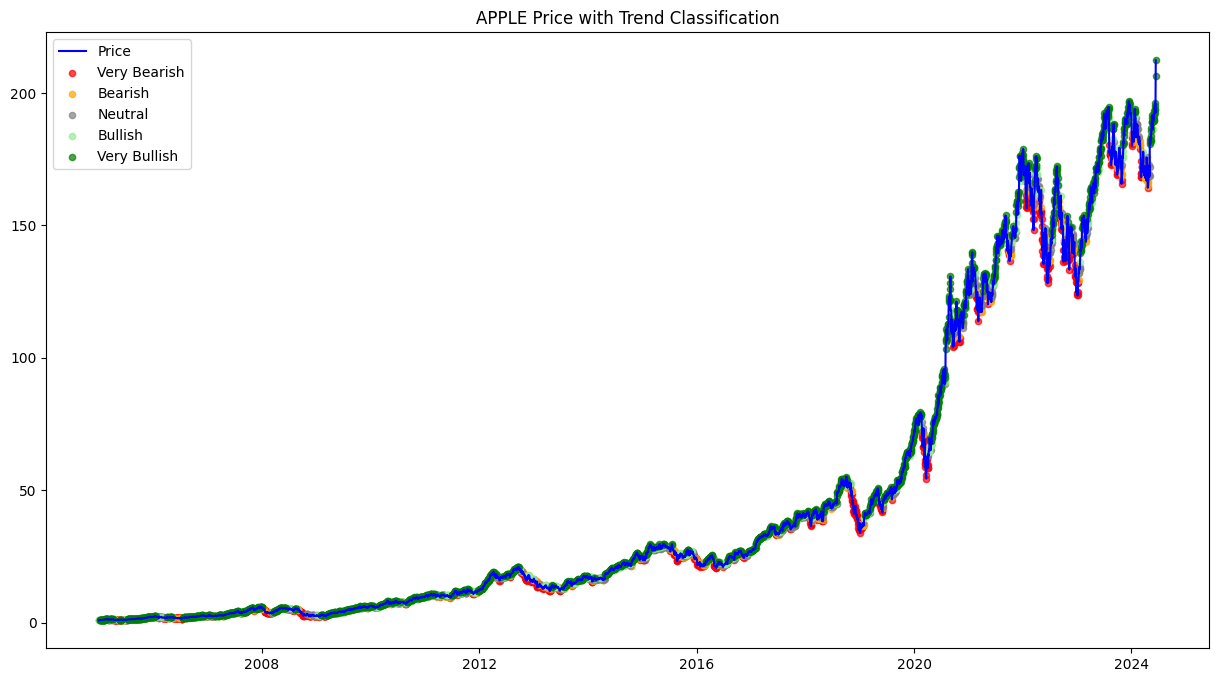


STRATEGY PERFORMANCE SUMMARY
Total Return: 3629.68%
Annualized Return: 23.52%
Sharpe Ratio: 1.41
Sortino Ratio: 2.05
Win Rate: 51.23%
Profit Factor: 1.54
Average Win: $10555.49
Average Loss: $-7186.07
Maximum Drawdown: 13.61%
Total Trades: 1907

Strategy Breakdown:
                 count   win_rate   avg_profit  total_profit  avg_hold
strategy                                                              
ml_based           901  55.271920  1723.295277  1.552689e+06  5.597114
trend_following   1006  47.614314  2064.599376  2.076987e+06  7.030815


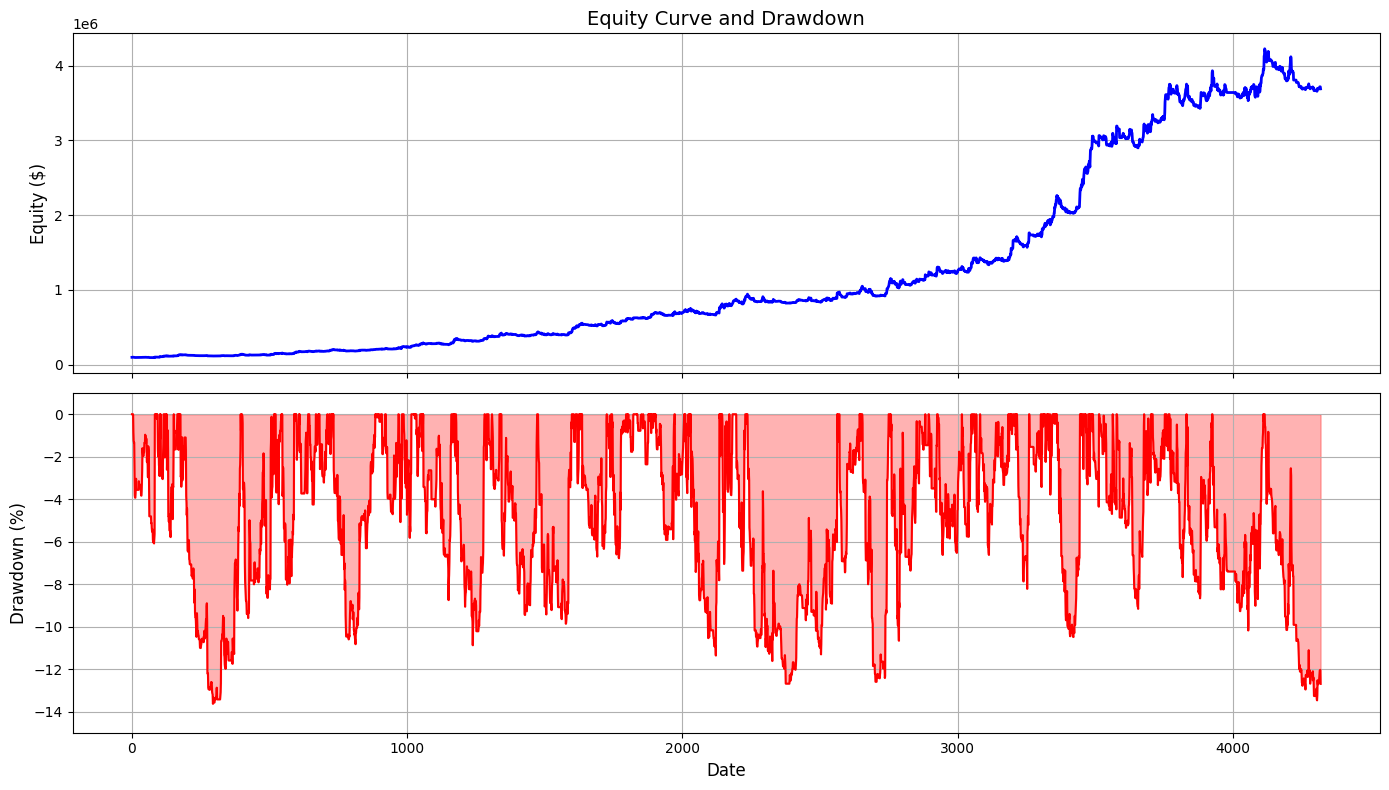

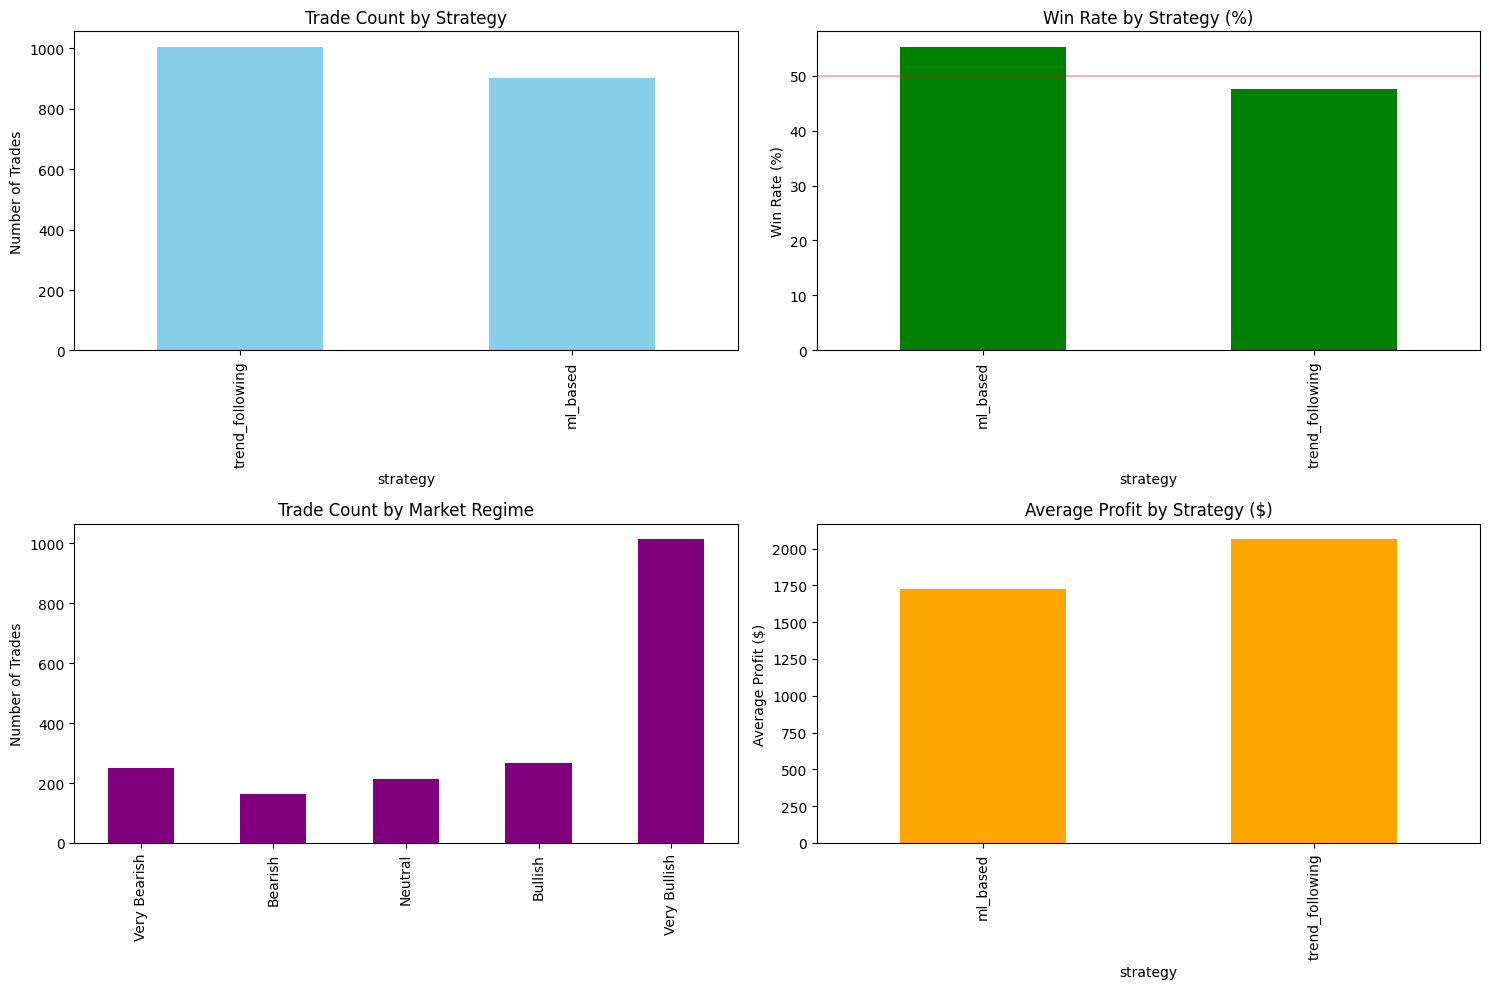


Performance by Market Regime:
              count   win_rate   avg_profit  total_profit
Very Bearish    251  52.589641  1184.025539  2.971904e+05
Bearish         162  48.148148   -70.870790 -1.148107e+04
Neutral         213  50.234742  1104.465832  2.352512e+05
Bullish         267  51.685393  2743.655731  7.325561e+05
Very Bullish   1014  51.479290  2343.352438  2.376159e+06

Performance by Exit Reason:
                 count    win_rate    avg_profit  total_profit
exit_reason                                                   
End of Backtest      5  100.000000   4797.278315  2.398639e+04
Stop Loss         1358   34.904271  -2372.004071 -3.221182e+06
Strategy Exit      126   64.285714   1413.709765  1.781274e+05
Take Profit        391  100.000000  16490.764370  6.447889e+06
Time Exit           27   96.296296   7439.068703  2.008549e+05


In [7]:
# --- 6. MAIN FUNCTION ---
def main():
    # Load and prepare data
    file_path = "AAPL_OHLCV.xlsx"
    #file_path = "eurusd-forex-data.xlsx"
    df = load_data(file_path)
    
    # Detect trends
    detector = EnhancedTrendDetector(smoothing_factor=5, change_threshold=0.3)
    features = detector.detect_trends(df)
    
    # Show trend distribution
    print("\nTrend Distribution:")
    distribution = features['trend_class'].value_counts().sort_index()
    trend_labels = ['Very Bearish', 'Bearish', 'Neutral', 'Bullish', 'Very Bullish']
    for i, count in distribution.items():
        print(f"{trend_labels[int(i)]}: {count} days ({count/len(features)*100:.1f}%)")
    
    # Plot price with trend classification
    plt.figure(figsize=(15, 8))
    plt.plot(df.index, df['close'], label='Price', color='blue')
    
    # Add colored dots for different trend classifications
    for trend_class, label, color in zip(range(5), trend_labels, ['red', 'orange', 'gray', 'lightgreen', 'green']):
        mask = features['trend_class'] == trend_class
        plt.scatter(features.index[mask], df.loc[features.index[mask], 'close'], 
                   label=label, color=color, alpha=0.7, s=20)
    
    plt.title('APPLE Price with Trend Classification')
    plt.legend()
    plt.show()
    
    # Train ML models if desired
    ml_predictor = MLTrendPredictor()
    ml_features = ml_predictor.prepare_features(pd.concat([df, features], axis=1))
    ml_results = ml_predictor.train_models(ml_features)
    ml_predictions = ml_predictor.predict(ml_features)
    
    # Run adaptive multi-strategy trading system
    strategy = AdaptiveMultiStrategyTrader(df, features, ml_predictions)
    results = strategy.run()
    
    # Additional analysis of results by strategy type
    if results and 'trades' in results and not results['trades'].empty:
        trades_df = results['trades']
        
        # Analyze performance by market regime
        regime_analysis = trades_df.groupby('trend_class').agg(
            count=('pnl', 'count'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100),
            avg_profit=('pnl', 'mean'),
            total_profit=('pnl', 'sum')
        )
        
        # Convert trend_class numbers to labels
        regime_analysis.index = [trend_labels[int(i)] for i in regime_analysis.index]
        
        print("\nPerformance by Market Regime:")
        print(regime_analysis)
        
        # Analyze performance by exit reason
        exit_analysis = trades_df.groupby('exit_reason').agg(
            count=('pnl', 'count'),
            win_rate=('pnl', lambda x: (x > 0).mean() * 100),
            avg_profit=('pnl', 'mean'),
            total_profit=('pnl', 'sum')
        )
        
        print("\nPerformance by Exit Reason:")
        print(exit_analysis)

if __name__ == "__main__":
    main()
